# Final Project

Team members: Enze Zhou, Vahan Geghamyan

## 1. Introduction

In this project, we want to implement the algorithms proposed by [Ma and Wu (2022)](#Ma2022) to accelerate the simulation of rough volatility processes. In particular, [Ma and Wu (2022)](#Ma2022) focuses on the rough Heston model

$$
\begin{equation}
\begin{aligned}
\mathrm{d} S_t &= r S_t \mathrm{d} t+S_t \sqrt{V_t} \mathrm{d} W_t, \\
V_t &= V_0+\frac{1}{\Gamma(1-\alpha)} \int_0^t(t-s)^{-\alpha} f\left(V_s\right) \mathrm{d} s + \frac{1}{\Gamma(1-\alpha)} \int_0^t(t-s)^{-\alpha} g\left(V_s\right) \mathrm{d} B_s, \\
t &\in [0, T], \ \alpha \in(0,1 / 2),
\end{aligned}
\end{equation}
$$

where $f(V_s) = \kappa (\theta - V_s)$, $g(V_s) = \kappa \epsilon \sqrt{V_s}$, and $\kappa, \theta, \epsilon$ are given positive constants.

## 2. Algorithms

### 2.1 Modified Euler-Maruyama algorithm

Let $\{t_n:=n \tau, n=0,1, \ldots, N\}$ be a given uniform mesh on $[0, T]$, where $N$ is a positive integer and $\tau=T / N$. At time level $t_n$, the stochastic Volterra integral equation is written as

$$
\begin{aligned}
V_{t_n}= V_0+\frac{1}{\Gamma(1-\alpha)} \int_0^{t_n}\left(t_n-s\right)^{-\alpha} f\left(V_s\right) \mathrm{d} s + \frac{1}{\Gamma(1-\alpha)} \int_0^{t_n}\left(t_n-s\right)^{-\alpha} g\left(V_s\right) \mathrm{d} B_s .
\end{aligned}
$$

We can then derive that 
$$
\begin{aligned}
V_{t_n} &= V_0+\frac{1}{\Gamma(1-\alpha)} \sum_{k=1}^n \int_{t_{k-1}}^{t_k}\left(t_n-s\right)^{-\alpha} f\left(V_s\right) \mathrm{d} s +\frac{1}{\Gamma(1-\alpha)} \sum_{k=1}^n \int_{t_{k-1}}^{t_k}\left(t_n-s\right)^{-\alpha} g\left(V_s\right) \mathrm{d} B_s \\
&\approx V_0+\frac{1}{\Gamma(1-\alpha)} \sum_{k=1}^n f\left(V_{t_{k-1}}\right) \int_{t_{k-1}}^{t_k}\left(t_n-s\right)^{-\alpha} \mathrm{d} s +\frac{1}{\Gamma(1-\alpha)} \sum_{k=1}^n g\left(V_{t_{k-1}}\right) \int_{t_{k-1}}^{t_k}\left(t_n-s\right)^{-\alpha} \mathrm{d} B_s \\
&= V_0+\frac{1}{\Gamma(2-\alpha)} \sum_{k=1}^n f\left(V_{t_{k-1}}\right) \times\left[\left(t_n-t_{k-1}\right)^{1-\alpha}-\left(t_n-t_k\right)^{1-\alpha}\right] +\frac{1}{\Gamma(1-\alpha)} \sum_{k=1}^n g\left(V_{t_{k-1}}\right) \int_{t_{k-1}}^{t_k}\left(t_n-s\right)^{-\alpha} \mathrm{d} B_s,
\end{aligned}
$$

where 

$$
\begin{aligned}
\int_{t_{k-1}}^{t_k}\left(t_n-s\right)^{-\alpha} \mathrm{d} B_s \sim \mathcal{N}\left(0, \int_{t_{k-1}}^{t_k}\left(t_n-s\right)^{-2 \alpha} \mathrm{d} s\right) =\mathcal{N}\left(0, \frac{\left(t_n-t_{k-1}\right)^{1-2 \alpha}-\left(t_n-t_k\right)^{1-2 \alpha}}{1-2 \alpha}\right)
\end{aligned}
$$

---

**Algorithm 1** (Modfied Euler-Maruyama algorithm): 

Let $\{t_n:=n \tau, n=0,1, \ldots, N\}$ be a given uniform mesh on $[0, T]$, where $N$ is a positive integer and $\tau=T / N$. At time level $t_n$, the stochastic Volterra integral equation is approximately written as

$$
\begin{aligned}
V_{t_n}^N &= V_0+\frac{1}{\Gamma(2-\alpha)} \sum_{k=1}^n f\left(V_{t_{k-1}}^N\right) \left[\left(t_n-t_{k-1}\right)^{1-\alpha}-\left(t_n-t_k\right)^{1-\alpha}\right] \\
&\quad +\frac{1}{\Gamma(1-\alpha)} \sum_{k=1}^n g\left(V_{t_{k-1}}^N\right) \left[\frac{\left(t_n-t_{k-1}\right)^{1-2 \alpha}-\left(t_n-t_k\right)^{1-2 \alpha}}{1-2 \alpha}\right]^{1 / 2} Z_{t_k},
\end{aligned}
$$

where $Z_{t_k} \sim \mathcal{N}(0,1)$

### 2.2 Fast algorithm


- It is hard to simulate the paths of the rough Heston model:

    - the volatility process contains an integral process and the kernel $(t − s)^{- \alpha}$ with $\alpha \in (0, 1/2)$ is singular at point $s = t$. 
    
    - The complexity of the Euler-Maruyama algorithm for simulating one path is $O(N^2)$ 

    - Since the integrand is singular at $s = t$, the discretization of the integral process needs special treatment to attain good accuracy. 
    
    
- Solution: approximating the kernel function by the sum of exponential functions. 



From the definition of $\Gamma$ function ([Olver et al., 2010](#Olver2010)), we can write the kernel function $t^{-\alpha}$ for $\alpha>0$ into an integral form

$$
t^{-\alpha}=\frac{1}{\Gamma(\alpha)} \int_0^{\infty} e^{-t s} s^{\alpha-1} \mathrm{~d} s .
$$

This is further written as for $t \in[\tau, T]$ and $\tau=T / N \in(0,1]$,

$$
\begin{aligned}
\Gamma(\alpha) t^{-\alpha}= & \int_0^{\infty} e^{-t s} s^{\alpha-1} \mathrm{~d} s \\
= & \int_0^{2^{-M}} e^{-t s} s^{\alpha-1} \mathrm{~d} s+\int_{2^{-M}}^{2^{N+1}} e^{-t s} s^{\alpha-1} \mathrm{~d} s  +\int_{2^{N+1}}^{\infty} e^{-t s} s^{\alpha-1} \mathrm{~d} s \\
\approx & \int_0^{2^{-M}} e^{-t s} s^{\alpha-1} \mathrm{~d} s+\sum_{j=-M}^{-1} \int_{2^j}^{2^{j+1}} e^{-t s} s^{\alpha-1} \mathrm{~d} s +\sum_{j=0}^N \int_{2^j}^{2^{j+1}} e^{-t s} s^{\alpha-1} \mathrm{~d} s,
\end{aligned}
$$

where $M=O[\log(T)]$ and $N=\left[O\left(\log\log\frac{1}{\xi}+\log\frac{1}{\tau}\right)\right]$. Then, with Gaussian quadrature (Gauss-Jacobi and Gauss-Legendre),

$$
\begin{aligned}
\Gamma(\alpha) t^{-\alpha} \approx & \sum_{k=1}^{n_o} e^{-s_{o, k} t} w_{o, k}+\sum_{j=-M}^{-1} \sum_{k=1}^{n_s} e^{-s_{j, k} t} s_{j, k}^{\alpha-1} w_{j, k} +\sum_{j=0}^N \sum_{k=1}^{n_l} e^{-s_{j, k} t} s_{j, k}^{\alpha-1} w_{j, k},
\end{aligned}
$$

where $n_o=\left[O\left(\log\frac{1}{\xi}\right)\right], n_s=\left[O\left(\log\frac{1}{\xi}\right)\right], n_l=\left[O\left(\log\frac{1}{\xi}+\log\frac{1}{\tau}\right)\right]$. This is re-written into the following compact form:

$$
t^{-\alpha} \approx \sum_{l=1}^{N_{\exp }} \omega_l e^{-x_l t},
$$

where

$$
\begin{aligned}
N_{\exp }= & \left[O \left(\log \frac{1}{\xi}\left(\log \log \frac{1}{\xi}+\log \frac{T}{\tau}\right) +\log \frac{1}{\tau}\left(\log \log \frac{1}{\xi} \log \frac{1}{\tau}\right)\right)\right]
\end{aligned}
$$

and

$$
\begin{aligned}
\{x_l, l=1, \ldots, N_{\exp} \} &=\{s_{o, 1}, \ldots, s_{o, n_o}\} \bigcup  \left(\bigcup_{j=-M}^{-1} \{s_{j, 1}, \ldots, s_{j, n_s}\}\right) \bigcup  \left(\bigcup_{j=0}^N \{s_{j, 1}, \ldots, s_{j, n_l} \}\right), \\
\{\omega_l,l=1, \ldots, N_{\exp}\} &= \{w_{o, 1} / \Gamma(\alpha), \ldots, w_{o, n_o} / \Gamma(\alpha)\} \bigcup\left(\bigcup_{j=-M}^{-1} \{s_{j, 1}^{\alpha-1} w_{j, 1} / \Gamma(\alpha), \ldots, s_{j, n_s}^{\alpha-1} w_{j, n_s} / \Gamma(\alpha) \}\right) \\
& \qquad\bigcup\left(\bigcup_{j=0}^N \{s_{j, 1}^{\alpha-1} w_{j, 1} / \Gamma(\alpha), \ldots, s_{j, n_l}^{\alpha-1} w_{j, n_l} / \Gamma(\alpha)\}\right) .
\end{aligned}
$$

Then, the approximation error of $t^{-\alpha}$ is given by [Jiang et al. (2017)](#Jiang2017):

$$
\left|t^{-\alpha}-\sum_{l=1}^{N_{\exp }} \omega_l e^{-x_l t}\right| \leq \xi, \quad \text { for } t \in[\tau, T].
$$

Next we derive the fast algorithm to solve the stochastic Volterra integral equation. Denote

$$
\begin{aligned}
I_1^n & :=\int_0^{t_n}\left(t_n-s\right)^{-\alpha} f\left(V_s\right) \mathrm{d} s, \\
I_2^n & :=\int_0^{t_n}\left(t_n-s\right)^{-\alpha} g\left(V_s\right) \mathrm{d} B_s .
\end{aligned}
$$

Then we use the approximation of the kernel, we obtain that

$$
\begin{aligned}
I_1^n &= \int_{t_{n-1}}^{t_n}\left(t_n-s\right)^{-\alpha} f\left(V_s\right) \mathrm{d} s+\int_0^{t_{n-1}}\left(t_n-s\right)^{-\alpha} f\left(V_s\right) \mathrm{d} s \\
&\approx \int_{t_{n-1}}^{t_n}\left(t_n-s\right)^{-\alpha} f\left(V_s\right) \mathrm{d} s+\int_0^{t_{n-1}} \sum_{l=1}^{N_{\text {exp }}} \omega_l e^{-x_l\left(t_n-s\right)} f\left(V_s\right) \mathrm{d} s \\
&= \int_{t_{n-1}}^{t_n}\left(t_n-s\right)^{-\alpha} f\left(V_s\right) \mathrm{d} s +\sum_{l=1}^{N_{\text {exp }}} \omega_l e^{-x_l \tau} \int_0^{t_{n-1}} e^{-x_l\left(t_{n-1}-s\right)} f\left(V_s\right) \mathrm{d} s \\
&\approx \frac{\tau^{1-\alpha}}{1-\alpha} f\left(V_{t_{n-1}}\right)+\sum_{l=1}^{N_{\text {exp }}} \omega_l e^{-x_l \tau} H_l\left(t_{n-1}\right),
\end{aligned}
$$

where $\tau=t_n-t_{n-1}=T/N$, and 

$$
\begin{aligned}
H_l\left(t_{n-1}\right) &:= \int_0^{t_{n-1}} e^{-x_l\left(t_{n-1}-s\right)} f\left(V_s\right) \mathrm{d} s \\
&= \int_{t_{n-2}}^{t_{n-1}} e^{-x_l\left(t_{n-1}-s\right)} f\left(V_s\right) \mathrm{d} s +e^{-x_l \tau} \int_0^{t_{n-2}} e^{-x_l\left(t_{n-2}-s\right)} f\left(V_s\right) \mathrm{d} s \\
&= \int_{t_{n-2}}^{t_{n-1}} e^{-x_l\left(t_{n-1}-s\right)} f\left(V_s\right) \mathrm{d} s+e^{-x_l \tau} H_l\left(t_{n-2}\right) \\
&\approx \frac{1-e^{-x_l \tau}}{x_l} f\left(V_{t_{n-2}}\right)+e^{-x_l \tau} H_l\left(t_{n-2}\right),
\end{aligned}
$$

with $H_l(t_0)=0$ for $1 \leq l \leq N_{\text{exp}}$. The decomposition of $I_2^n$ is similar:

$$
\begin{aligned}
I_2^n & =\int_{t_{n-1}}^{t_n}\left(t_n-s\right)^{-\alpha} g\left(V_s\right) \mathrm{d} B_s+\sum_{l=1}^{N_{\text {exp }}} \omega_l e^{-x_l \tau} J_l\left(t_{n-1}\right) \\
& \approx \tau^{-\alpha} g\left(V_{t_{n-1}}\right)\left(B_{t_n}-B_{t_{n-1}}\right)+\sum_{l=1}^{N_{\text {exp }}} \omega_l e^{-x_l \tau} J_l\left(t_{n-1}\right), \\
& = \frac{\tau^{\frac{1}{2}-\alpha}}{(1-2 \alpha)^{\frac{1}{2}}} g\left(V_{t_{n-1}}\right) Z_{t_n}+\sum_{l=1}^{N_{\text {exp }}} \omega_l e^{-x_l \tau} J_l\left(t_{n-1}\right), \\
J_l\left(t_{n-1}\right) &:=  \int_0^{t_{n-1}} e^{-x_l\left(t_{n-1}-s\right)} g\left(V_s\right) \mathrm{d} s \\
&= \int_{t_{n-2}}^{t_{n-1}} e^{-x_l\left(t_{n-1}-s\right)} g\left(V_s\right) \mathrm{d} B_s +e^{-x_l \tau} \int_0^{t_{n-2}} e^{-x_l\left(t_{n-2}-s\right)} g\left(V_s\right) \mathrm{d} B_s \\
&= \int_{t_{n-2}}^{t_{n-1}} e^{-x_l\left(t_{n-1}-s\right)} g\left(V_s\right) \mathrm{d} B_s+e^{-x_l \tau} J_l\left(t_{n-2}\right) \\
&\approx \sqrt{\frac{1-e^{-2x_l \tau}}{2 x_l}} g\left(V_{t_{n-2}}\right) Z_{t_{n-1}}+e^{-x_l \tau} J_l\left(t_{n-2}\right).
\end{aligned}
$$
Combining all, we have the Fast algorithm.

---

**Algorithm 2** (Fast algorithm) The fast algorithm for simulation of (2) is given by

$$
\begin{aligned}
V_{t_n}^N &= V_0+\frac{\tau^{1-\alpha}}{\Gamma(2-\alpha)} f\left(V_{t_{n-1}}^N\right) +\frac{1}{\Gamma(1-\alpha)} \sum_{l=1}^{N_{\text {exp }}} \omega_l e^{-x_l \tau} H_l^N\left(t_{n-1}\right) \\
& \quad +\frac{\tau^{\frac{1}{2}-\alpha}}{\sqrt{1-2\alpha}\  \Gamma(1-\alpha)} g\left(V_{t_{n-1}}^N\right) Z_{t_n} +\frac{1}{\Gamma(1-\alpha)} \sum_{l=1}^{N_{\text {exp }}} \omega_l e^{-x_l \tau} J_l^N\left(t_{n-1}\right), \quad n=1, \ldots, N, \\
H_l^N\left(t_{n-1}\right) &= \frac{f\left(V_{t_{n-2}}^N\right)}{x_l}\left(1-e^{-x_l \tau}\right)+e^{-x_l \tau} H_l^N\left(t_{n-2}\right), \quad n=2, \ldots, N, \\
J_l^N\left(t_{n-1}\right) &= \sqrt{\frac{1-e^{-2 x_l \tau}}{2 x_l}}  g\left(V_{t_{n-2}}^N\right) Z_{t_{n-1}}+e^{-x_l \tau} J_l^N\left(t_{n-2}\right), \quad n=2, \ldots, N,
\end{aligned}
$$

with $V_{t_0}^N=V_0, H_l^N\left(t_0\right)=0, J_l^N\left(t_0\right)=0, \tau=T / N, Z_{t_n} \sim$ $\mathcal{N}(0,1)$ for $n=1, \ldots, N$.


### 2.3 Multi-factor approximation algorithm

[Abi Jaber and El Euch (2019)](#AbiJaber2019) approximate the kernel function by

$$
\frac{t^{-\alpha}}{\Gamma(1-\alpha)} \approx \sum_{j=1}^{\widetilde{N}_{\text {exp }}} c_j e^{-\gamma_j t},
$$

with 

$$
\begin{aligned}
& c_j:=\int_{\eta_{j-1}}^{\eta_j} \mu(d \gamma), \quad \gamma_j:=\frac{1}{c_j} \int_{\eta_{j-1}}^{\eta_j} \gamma \mu(d \gamma), \\
& \eta_j:=j \frac{\widetilde{N}_{\exp }^{-1 / 5}}{T}\left(\frac{\sqrt{10} \alpha}{2+\alpha}\right)^{2 / 5}, \quad \mu(d \gamma):=\frac{\gamma^{\alpha-1}}{\Gamma(1-\alpha) \Gamma(\alpha)} \mathrm{d} \gamma.
\end{aligned}
$$

Next, the rough Heston model is approximated by the following multi-factor Heston model

$$
\begin{aligned}
V_t^{\widetilde{N}_{\text {exp}}} & =V_0+\kappa \theta \sum_{j=1}^{\widetilde{N}_{\text {exp}}} \frac{c_j}{\gamma_j}\left(1-e^{-\gamma_j t}\right)+\sum_{j=1}^{\widetilde{N}_{\text {exp}}} c_j V_t^{\widetilde{N}_{\text {exp}}, j}, \\
d V_t^{\widetilde{N}_{\text {exp}}, j} & =\left(-\gamma_j V_t^{\widetilde{N}_{\text {exp}}, j}-\kappa V_t^{\widetilde{N}_{\text {exp}}}\right) \mathrm{d} t+g\left(V_t^{\widetilde{N}_{\text {exp}}}\right) \mathrm{d} B_t,
\end{aligned}
$$

with $V_0^{\widetilde{N}_{\text {exp}}, j} = 0$, for $j=1, \ldots, \tilde{N}_{\text{exp}}$.

---

Algorithm 4 (Multi-factor approximation algorithm, [Abi Jaber et al. (2019)](#AbiJaber2019)) Let $V_{t_n}^{\widetilde{N}_\text{exp}, N}$ and $V_{t_n}^{\tilde{N}_{\text{exp}}, j, N}$ denote the approximation of $V_{t_n}^{\tilde{N}_{\text{exp}}}$ and $V_{t_n}^{\tilde{N}_{\text{exp}}, j}$, respectively, for $n=0,1, \ldots, N$. Then the algorithm for simulation of rough Heston model given by

$$
\begin{aligned}
& V_{t_n}^{\widetilde{N}_{\text{exp}}, N}=V_{t_0}^{\widetilde{N}_{\text{exp}}, N}+\kappa \theta \sum_{j=1}^{\tilde{N}_{\text{exp}}} \frac{c_j}{\gamma_j}\left(1-e^{-\gamma_j t_n}\right)+\sum_{j=1}^{\tilde{N}_{\text{exp}}} c_j V_{t_n}^{\widetilde{N}_{\text{exp}}, j, N}, \\
& V_{t_n}^{\widetilde{N}_{\text{exp}}, j, N}=\frac{V_{t_{n-1}}^{\widetilde{N}_{\text{exp}}, j, N}-\kappa V_{t_{n-1}}^{\widetilde{N}_{\text{exp}}, N} \tau+g\left(V_{t_{n-1}}^{\widetilde{N}_{\text{exp}}, N}\right) \sqrt{\tau} Z_{t_n}}{1+\gamma_j \tau}, \\
& j=1,2, \ldots, \widetilde{N}_{\text{exp}}, \\
\end{aligned}
$$

where $V_{t_0}^{\tilde{N}_{\text{exp}}, N}=V_0, V_{t_0}^{\widetilde{N}_{\text{exp}}, N}=0, \tau=T / N, Z_{t_n} \sim \mathcal{N}(0,1)$ for $n=1, \ldots, N$, and $c_j, \gamma_j, \eta_j$ are given by (27). It thus gives the simulation of the rough Heston model (29) with $V_{t_n} \approx$ $V_{t_n}^{\widetilde{N}_{\text{exp}}, N}$ for $n=0,1, \ldots, N$.

## 3. Usage with PyFENG

In [1]:
import numpy as np
from PyFENG import pyfeng as pf
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
rheston_038 = pf.RoughHestonMcMaWu2022(V_0=0.0392, rho=-0.681, kappa=0.1, epsilon=0.331, theta=0.3156, alpha=0.38) # initialize the model

In [3]:
rheston_038.set_num_params(texp=1, n_path=1_000, n_ts=1_000) # set the time to maturity, number of paths, and number of time steps
Z_t, W_t = rheston_038.random_normals() # generate the random normals for simulation
V_t = rheston_038.Fast(Z_t) # simulate the volatility process (in this case the Fast algorithm is used)
K = np.linspace(80, 120, 9) # strikes
rheston_038.price(S_0=100, V_t=V_t, W_t=W_t, K=K)[1] # price European options

array([21.72369424, 18.00546798, 14.67712227, 11.78229631,  9.25290636,
        7.10528434,  5.39333587,  4.02672248,  2.95495577])

## 4. Experiments

### 4.1 Comparison among three algorithms

In [4]:
rheston_038 = pf.RoughHestonMcMaWu2022(V_0=0.0392, rho=-0.681, kappa=0.1, epsilon=0.331, theta=0.3156, alpha=0.38)
rheston_002 = pf.RoughHestonMcMaWu2022(V_0=0.0392, rho=-0.681, kappa=0.1, epsilon=0.331, theta=0.3156, alpha=0.02)

In [5]:
def generate_paths(model, texp=1, n_path=1000, n_ts=1000, rn_seed=1):
    m_038, m_002 = model[0], model[1]

    m_038.set_num_params(texp=texp, n_path=n_path, n_ts=n_ts, rn_seed=rn_seed)
    Z_t1, W_t1 = m_038.random_normals()
    V_t_038 = m_038.ModifiedEM(Z_t1)
    V_t_038_fast = m_038.Fast(Z_t1, 1e-4)
    V_t_038_multifactor = m_038.MultifactorApprox(Z_t1)

    m_002.set_num_params(texp=texp, n_path=n_path, n_ts=n_ts, rn_seed=rn_seed)
    Z_t2, W_t2 = m_002.random_normals()
    V_t_002 = m_002.ModifiedEM(Z_t2)
    V_t_002_fast = m_002.Fast(Z_t2, 1e-4)
    V_t_002_multifactor = m_002.MultifactorApprox(Z_t2)

    return V_t_038, V_t_038_fast, V_t_038_multifactor, V_t_002, V_t_002_fast, V_t_002_multifactor

In [6]:
def plot_comparison(model, vol_paths, type='alpha'):
    m_038, m_002 = model[0], model[1]
    V_t_038, V_t_038_fast, V_t_038_multifactor, V_t_002, V_t_002_fast, V_t_002_multifactor = vol_paths[0], vol_paths[1], vol_paths[2], vol_paths[3], vol_paths[4], vol_paths[5]

    if type == 'alpha':
        fig, ax = plt.subplots(3, 1, figsize=(10, 18))
        ax[0].plot(m_038.tgrid, V_t_038[:, 500], lw=0.5, label=r'$\alpha=0.38$')
        ax[0].plot(m_002.tgrid, V_t_002[:, 500], lw=0.5, label=r'$\alpha=0.02$')
        ax[0].legend()
        ax[0].set_title('Euler-Maruyama paths')
        ax[0].set_xlabel(r'$t$')
        ax[0].set_ylabel(r'$V_t$')
        
        ax[1].plot(m_038.tgrid, V_t_038_fast[:, 500], lw=0.5, label=r'$\alpha=0.38$')
        ax[1].plot(m_002.tgrid, V_t_002_fast[:, 500], lw=0.5, label=r'$\alpha=0.02$')
        ax[1].legend()
        ax[1].set_title('Fast paths')
        ax[1].set_xlabel(r'$t$')
        ax[1].set_ylabel(r'$V_t$')

        ax[2].plot(m_038.tgrid, V_t_038_multifactor[:, 500], lw=0.5, label=r'$\alpha=0.38$')
        ax[2].plot(m_002.tgrid, V_t_002_multifactor[:, 500], lw=0.5, label=r'$\alpha=0.02$')
        ax[2].legend()
        ax[2].set_title('Multifactor approximation paths')
        ax[2].set_xlabel(r'$t$')
        ax[2].set_ylabel(r'$V_t$')
        plt.savefig('alpha_comparison.svg')
        plt.show()
    elif type == 'algo':
        fig, ax = plt.subplots(2, 1, figsize=(10, 12))
        ax[0].plot(m_038.tgrid, V_t_038[:, 500], lw=0.5, label='Modified Euler-Maruyama')
        ax[0].plot(m_038.tgrid, V_t_038_fast[:, 500], lw=0.5, label='Fast algorithm')
        ax[0].plot(m_038.tgrid, V_t_038_multifactor[:, 500], lw=0.5, label='Multifactor approximation')
        ax[0].legend()
        ax[0].set_title(r'Comparison of paths for $\alpha=0.38$')
        ax[0].set_xlabel(r'$t$')
        ax[0].set_ylabel(r'$V_t$')

        ax[1].plot(m_002.tgrid, V_t_002[:, 500], lw=0.5, label='Modified Euler-Maruyama')
        ax[1].plot(m_002.tgrid, V_t_002_fast[:, 500], lw=0.5, label='Fast algorithm')
        ax[1].plot(m_002.tgrid, V_t_002_multifactor[:, 500], lw=0.5, label='Multifactor approximation')
        ax[1].legend()
        ax[1].set_title(r'Comparison of paths for $\alpha=0.02$')
        ax[1].set_xlabel(r'$t$')
        ax[1].set_ylabel(r'$V_t$')
        plt.savefig('algo_comparison.svg')
        plt.show()
    else:
        raise ValueError('Invalid type or algo')

In [7]:
models = (rheston_038, rheston_002)
vol_paths = generate_paths(models, n_path=1000, n_ts=1000, rn_seed=1)

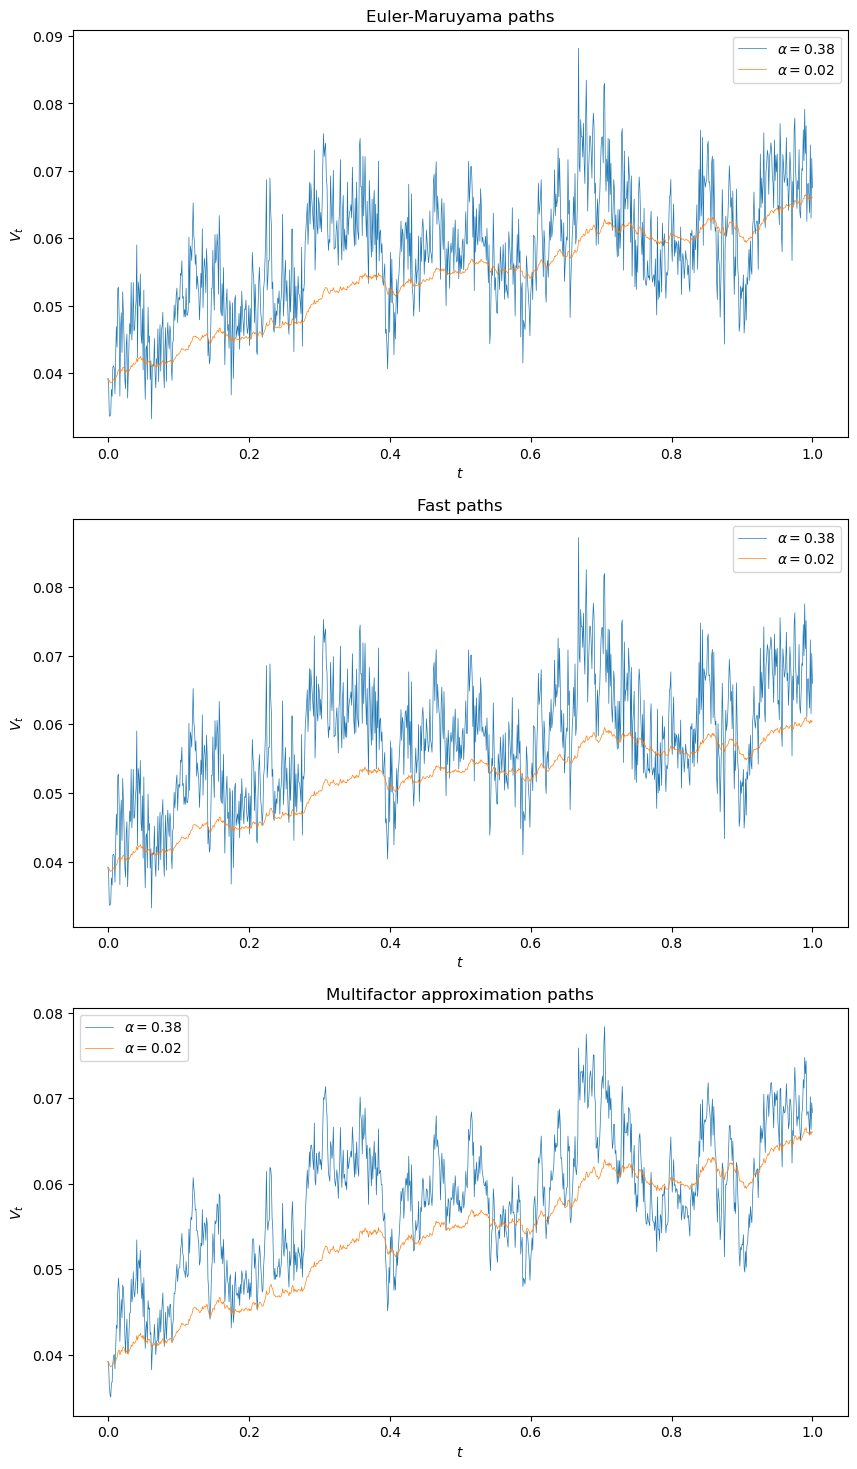

In [8]:
plot_comparison(models, vol_paths, type='alpha')

Observations:
- the paths generated by the Modified Euler-Maruyama algorithm and the Fast algorithm exhibit the same extent of roughness when $\alpha=0.38$, while the paths from the Multifactor approximation algorithm seems smoother.
- the paths of $\alpha=0.38$ is much rougher than that of $\alpha=0.02$, obviously and intuitively

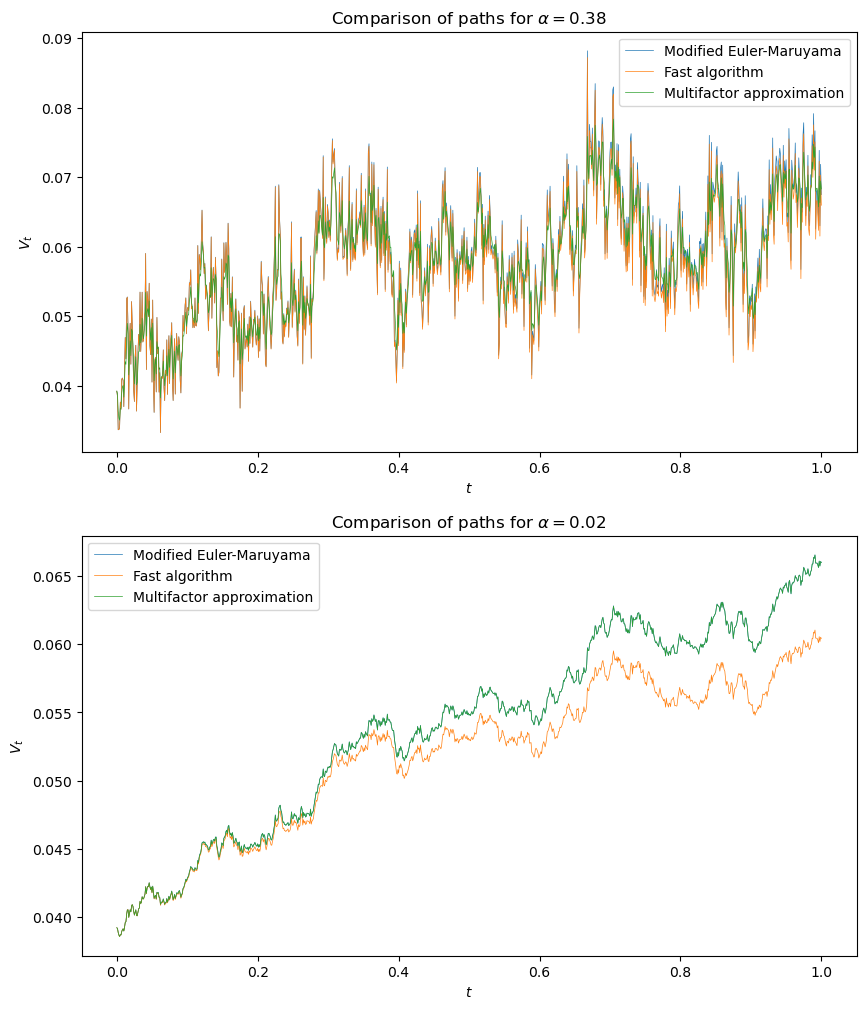

In [9]:
plot_comparison(models, vol_paths, type='algo')

Observations:
- when $\alpha=0.38$, the Fast algorithm generates very similar paths to that of the Modified Euler-Maruyama algorithm
- While when $\alpha=0.02$, the Multi-factor approximation algorithm instead generates very similar paths to that of the Modified Euler-Maruyama algorithm.
- the gap between the Fast algorithm and the Modified Euler-Maruyama algorithm widens as time evolves

### 4.2 Computation time

For $T=1$,

|      |        One path             | One path | 1000 paths simultaneously | 1000 paths simultaneously |
| ---- | -------------- | ---------- | -------------- | --------- |
| # time step | Euler-Maruyama | Fast       | Euler-Maruyama | Fast      |
| 250  | 6.615250       | 8.578748   | 0.115804       | 0.185450  |
| 500  | 14.519335      | 17.271443  | 0.592969       | 0.415592  |
| 1000 | 38.725009      | 34.958345  | 2.544576       | 1.085544  |
| 2000 | 113.862958     | 69.938801  | 8.690365       | 2.323525  |
| 4000 | 368.988235     | 141.535237 | 41.461980      | 5.271604  |
| 6000 | 1391.173844    | 290.813273 | 169.880603     | 15.053457 |

The above computation time is measured in milliseconds (ms). We can see that
- when time step is large, the Fast algorithm takes less time; when time step is small, the Modified Euler-Maruyama algorithm takes less time
- due to vectorization, the average time for generating one path in the latter case, generating 1000 paths simultaneously, is significantly shorter (up to **45x faster**)

#### 4.2.1 Time for one path

In [10]:
import timeit

def test_computation_time(model, texp, n_path, n_ts, algo, num_runs=100):
    method = getattr(model, algo)
    avg_time = np.zeros_like(n_ts, dtype=float)
    total_time = 0

    for i in range(len(n_ts)):
        total_time = 0
        model.set_num_params(texp=texp, n_path=n_path, n_ts=n_ts[i])
        for _ in range(num_runs):
            start_time = timeit.default_timer()

            Z_t1, W_t = model.random_normals()
            V_t = method(Z_t1)

            end_time = timeit.default_timer()

            total_time += end_time - start_time
        avg_time[i] = total_time / num_runs

    return avg_time

In [11]:
n_ts = [250, 500, 1000, 2000, 4000, 8000]
time_EM_1 = test_computation_time(rheston_038, texp=1, n_path=1, n_ts=n_ts, algo='ModifiedEM', num_runs=100)
time_Fast_1 = test_computation_time(rheston_038, texp=1, n_path=1, n_ts=n_ts, algo='Fast', num_runs=100)

In [12]:
comp_time_1 = pd.DataFrame(np.array([time_EM_1 * 1000, time_Fast_1 * 1000]).T, columns=['Euler-Maruyama', 'Fast'], index=n_ts)
comp_time_1

,Euler-Maruyama,Fast
250,6.744319,8.445443
500,14.561254,17.032287
1000,38.641519,34.543981
2000,113.698911,69.196658
4000,371.780909,141.271678
8000,1585.762850,288.271884


#### 4.2.2 Time for 1000 paths

In [13]:
time_EM_1000 = test_computation_time(rheston_038, texp=1, n_path=1000, n_ts=n_ts, algo='ModifiedEM', num_runs=5)
time_Fast_1000 = test_computation_time(rheston_038, texp=1, n_path=1000, n_ts=n_ts, algo='Fast', num_runs=100)

In [14]:
comp_time_1000 = pd.DataFrame(np.array([time_EM_1000, time_Fast_1000]).T, columns=['Euler-Maruyama', 'Fast'], index=n_ts)
comp_time_1000

,Euler-Maruyama,Fast
250,0.119882,0.186188
500,0.573104,0.406858
1000,2.415901,1.110461
2000,8.581143,2.479270
4000,41.058970,5.742832
8000,171.909454,15.446166


### 4.3 Option pricing

Use the same parameters from [Callegaro et al. (2021)](#Callegaro2021), 

$$
S_0=100, \quad V_0=0.0392, \quad \rho=-0.681, \quad \kappa=0.1, \quad \theta=0.3156, \quad \epsilon=0.331, \quad r=0 .
$$

Run the simulation with number of time steps $250$, number of paths $100,000$. Repeat the experiment for $100$ times (note that every time you run you might get different results due to the very nature of MC simulation).

- $\alpha=0.38$:

    | Strike | Algorithm type | One day | One week | One month | Six months | One year | Two years |
    | --- | --- | --- | --- | --- | --- | --- | --- |
    | 80 | [Callegaro et al. (2021)](#Callegaro2021) | 20 | 20 | 20.0005 | 20.6112 | 22.1366 | 25.4301 |
    |  | Modified EM | 19.99995     | 19.999989 | 20.000658 | 20.607918  | 22.120343 | 25.396956 |
    |  | Fast | 20.000033 | 20.001227 | 20.000293 | 20.610202 | 22.099119 | 25.334411 |
    | 85 | [Callegaro et al. (2021)](#Callegaro2021) | 15 | 15 | 15.0108 | 16.2807 | 18.3529 | 22.2091 |
    |  | Modified EM | 14.99995     | 14.999989 | 15.010846 | 16.274347  | 18.332555 | 22.171247 |
    |  | Fast | 15.000033 | 15.001227 | 15.010417 | 16.274096 | 18.304116 | 22.102681 |
    | 90 | [Callegaro et al. (2021)](#Callegaro2021) | 10 | 10.0002 | 10.1144 | 12.3948 | 14.9672 | 19.2898 |
    |  | Modified EM | 9.999954     | 10.000185 | 10.113493 | 12.384250  | 14.942785 | 19.247781 |
    |  | Fast | 10.000033 | 10.001414 | 10.113269 | 12.382012 | 14.909042 | 19.174900 |
    | 95 | [Callegaro et al. (2021)](#Callegaro2021) | 5.0003 | 5.0491 | 5.6723 | 9.0636 | 12.0059 | 16.6676 |
    |  | Modified EM | 4.999954     | 5.044462  | 5.669319  | 9.049536   | 11.977843 | 16.621762 |
    |  | Fast | 5.000034 | 5.045720 | 5.668659 | 9.045364 | 11.940542 | 16.546432 |
    | 100 | [Callegaro et al. (2021)](#Callegaro2021) | 0.5012 | 1.1347 | 2.3896 | 6.3497 | 9.4737 | 14.3319 |
    |  | Modified EM | 0.4147314    | 1.112365  | 2.384964  | 6.334239   | 9.443891  | 14.283308 |
    |  | Fast | 0.414964 | 1.112882 | 2.383228 | 6.328224 | 9.405186 | 14.206878 |
    | 105 | [Callegaro et al. (2021)](#Callegaro2021) | 6.39e-05 | 0.04113 | 0.6809 | 4.2550 | 7.3563 | 12.2676 |
    |  | Modified EM | 1.266341e-09 | 0.036536  | 0.677000  | 4.239743   | 7.326027  | 12.217084 |
    |  | Fast | 0.000000 | 0.036734 | 0.676066 | 4.233135 | 7.288169 | 12.140966 |
    | 110 | [Callegaro et al. (2021)](#Callegaro2021) | 2.37e-05 | 9.22e-05 | 0.1205 | 2.7251 | 5.6234 | 10.4562 |
    |  | Modified EM | 0.000000     | 6.3e-05   | 0.119173  | 2.711442   | 5.594169  | 10.404734 |
    |  | Fast | 0.000000 | 6.8e-05 | 0.118633 | 2.705616 | 5.558681 | 10.329619 |
    | 115 | [Callegaro et al. (2021)](#Callegaro2021) | 1.51e-05 | 6.82e-09 | 0.0124 | 1.6680 | 4.2343 | 8.8773 |
    |  | Modified EM | 0.000000     | 0.000000  | 0.012148  | 1.656444   | 4.206951  | 8.825911  |
    |  | Fast | 0.000000 | 0.000000 | 0.012179 | 1.652153 | 4.174740 | 8.753055 |
    | 120 | [Callegaro et al. (2021)](#Callegaro2021) | 1.14e-05 | 1.80e-13 | 7.32e-04 | 0.9761 | 3.1424 | 7.5093 |
    |  | Modified EM | 0.000000 | 0.000000 | 6.88e-04 | 0.967280 | 3.117224 | 7.458775 |
    |  | Fast | 0.000000 | 0.000000 | 6.97e-04 | 0.964104 | 3.089237 | 7.389633 |

- $\alpha=0.0001$ (approximation of regular Heston): 

    | Strike | Algorithm type | One day | One week | One month | Six months | One year | Two years |
    | --- | --- | --- | --- | --- | --- | --- | --- |
    | 80 | Heston FFT | 19.999817    | 20.00000     | 20.000119 | 20.467789  | 21.882194 | 25.342685 |
    |  | Modified EM | 20.00000     | 20.00032     | 19.998105 | 20.462389  | 21.860666 | 25.300803 |
    |  | Fast | 19.99991     | 19.99955     | 19.999065 | 20.452699  | 21.769390 | 25.009149 |
    | 85 | Heston FFT | 14.999592    | 15.00000     | 15.005036 | 16.065825  | 18.044783 | 22.116098 |
    |  | Modified EM | 15.00000     | 15.00032     | 15.002900 | 16.057406  | 18.019379 | 22.070199 |
    |  | Fast | 14.99991     | 14.99955     | 15.003894 | 16.039038  | 17.902571 | 21.743280 |
    | 90 | Heston FFT | 9.999253     | 10.00005     | 10.081315 | 12.117169  | 14.618737 | 19.193730 |
    |  | Modified EM | 9.999998     | 10.00037     | 10.078289 | 12.105610  | 14.590280 | 19.144437 |
    |  | Fast | 9.999908     | 9.999596     | 10.079303 | 12.079071  | 14.452885 | 18.790030 |
    | 95 | Heston FFT | 5.000421     | 5.033864     | 5.594002  | 8.749388   | 11.634501 | 16.570951 |
    |  | Modified EM | 4.999998     | 5.033804     | 5.589046  | 8.735251   | 11.604186 | 16.519429 |
    |  | Fast | 4.999908     | 5.033018     | 5.589339  | 8.703727   | 11.453570 | 16.146129 |
    | 100 | Heston FFT | 0.416402     | 1.097419     | 2.312255  | 6.033819   | 9.098308  | 14.236957 |
    |  | Modified EM | 0.4127088    | 1.095381     | 2.306016  | 6.018755   | 9.067458  | 14.184353 |
    |  | Fast | 0.4126009    | 1.095105     | 2.306729  | 5.986315   | 8.912003  | 13.800273 |
    | 105 | Heston FFT | -0.000445    | 4.138453e-02 | 0.651703  | 3.969527   | 6.994116  | 12.176208 |
    |  | Modified EM | 4.170842e-07 | 4.093408e-02 | 0.647528  | 3.955276   | 6.964014  | 12.123773 |
    |  | Fast | 2.615896e-07 | 4.097443e-02 | 0.648274  | 3.925360   | 6.812002  | 11.736762 |
    | 110 | Heston FFT | 0.000120     | 1.583470e-04 | 0.119056  | 2.490984   | 5.288288  | 10.369848 |
    |  | Modified EM | 0.000000     | 1.592360e-04 | 0.117548  | 2.478975   | 5.260181  | 10.318662 |
    |  | Fast | 0.000000     | 1.542381e-04 | 0.118001  | 2.454275   | 5.118236  | 9.936108  |
    | 115 | Heston FFT | -0.000369    | 5.558204e-08 | 0.013874  | 1.492120   | 3.935542  | 8.796976  |
    |  | Modified EM | 0.000000     | 7.617007e-08 | 0.013623  | 1.482647   | 3.910486  | 8.747960  |
    |  | Fast | 0.000000     | 3.838055e-08 | 0.013592  | 1.464176   | 3.783029  | 8.375640  |
    | 120 | Heston FFT | 0.000544 | 4.916068e-10 | 0.001038 | 0.854310 | 2.884879 | 7.435743 |
    |  | Modified EM | 0.000000 | 0.000000 | 0.000991 | 0.847441 | 2.863103 | 7.389376 |
    |  | Fast | 0.000000 | 0.000000 | 0.000979 | 0.834522 | 2.753132 | 7.032559 |

Observations:
- for both cases the Modified Euler-Maruyama algorithm is more accurate in terms of pricing European call options
- both methods exhibit downward biases compared to [Callegaro et al. (2021)](#Callegaro2021) in the case of $\alpha=0.38$
- both methods are quite accurate when the time to maturity is **less than one year**
- both methods approximate well the regular Heston case when the roughness parameter is set to be $\alpha=0.0001$

In [4]:
def generate_prices(alpha, method, cond=False, correct_fwd=False):
    rheston = pf.RoughHestonMcMaWu2022(V_0=0.0392, rho=-0.681, kappa=0.1, epsilon=0.331, theta=0.3156, alpha=alpha)
    prices = []
    texp = [1/365, 7/365, 1/12, 1/2, 1, 2]
    K = np.linspace(80, 120, 9)

    if not cond:
        if method == 'MEM':
            for t in texp:
                rheston.set_num_params(texp=t, n_path=100_000, n_ts=250)
                temp = []
                for i in range(100):
                    Z_t, W_t = rheston.random_normals()
                    V_t = rheston.ModifiedEM(Z_t)
                    temp += [rheston.price(S_0=100, V_t=V_t, W_t=W_t, K=K)[1]]
                temp = np.array(temp)
                prices += [temp.mean(axis=0)]
                print(f"texp = {t} done")
        elif method == 'Fast':
            for t in texp:
                rheston.set_num_params(texp=t, n_path=100_000, n_ts=250)
                temp = []
                for i in range(100):
                    Z_t, W_t = rheston.random_normals()
                    V_t = rheston.Fast(Z_t)
                    temp += [rheston.price(S_0=100, V_t=V_t, W_t=W_t, K=K)[1]]
                temp = np.array(temp)
                prices += [temp.mean(axis=0)]
                print(f"texp = {t} done")
        else:
            raise ValueError("Invalid method")
    elif cond:
        if method == 'MEM':
            for t in texp:
                rheston.set_num_params(texp=t, n_path=1_000, n_ts=250)
                temp = []
                for i in range(100):
                    Z_t, W_t = rheston.random_normals()
                    V_t = rheston.ModifiedEM(Z_t)
                    temp += [rheston.priceCMC(spot=100, V_t=V_t, Z_t=Z_t, K=K, correct_fwd=correct_fwd)]
                temp = np.array(temp)
                prices += [temp.mean(axis=0)]
                print(f"texp = {t} done")
        elif method == 'Fast':
            for t in texp:
                rheston.set_num_params(texp=t, n_path=1_000, n_ts=250)
                temp = []
                for i in range(100):
                    Z_t, W_t = rheston.random_normals()
                    V_t = rheston.Fast(Z_t)
                    temp += [rheston.priceCMC(spot=100, V_t=V_t, Z_t=Z_t, K=K, correct_fwd=correct_fwd)]
                temp = np.array(temp)
                prices += [temp.mean(axis=0)]
                print(f"texp = {t} done")
        else:
            raise ValueError("Invalid method")
    else:
        raise ValueError("Invalid condition")
        
    prices = np.array(prices)
    columns = ['One day', 'One week', 'One month', 'Six months', 'One year', 'Two years']
    prices_df = pd.DataFrame(prices.T, columns=columns, index=K)

    return prices_df

#### 4.3.1 $\alpha=0.38$

In [16]:
prices_038_EM_df = generate_prices(0.38, 'MEM')

texp = 0.0027397260273972603 done
texp = 0.019178082191780823 done
texp = 0.08333333333333333 done
texp = 0.5 done
texp = 1 done
texp = 2 done


In [17]:
prices_038_Fast_df = generate_prices(0.38, 'Fast')

texp = 0.0027397260273972603 done
texp = 0.019178082191780823 done
texp = 0.08333333333333333 done
texp = 0.5 done
texp = 1 done
texp = 2 done


In [18]:
prices_038_EM_df

,One day,One week,One month,Six months,One year,Two years
80.0,2.000028e+01,20.000002,20.000866,20.609116,22.119000,25.401438
85.0,1.500028e+01,15.000002,15.010992,16.275198,18.332142,22.175704
90.0,1.000028e+01,10.000201,10.113523,12.385482,14.943232,19.251920
95.0,5.000281e+00,5.044621,5.668401,9.050601,11.979029,16.625879
100.0,4.150454e-01,1.112772,2.383434,6.334449,9.445165,14.287567
105.0,9.461528e-08,0.036614,0.676531,4.238665,7.327901,12.221528
110.0,0.000000e+00,0.000063,0.118929,2.709339,5.596792,10.409755
115.0,0.000000e+00,0.000000,0.012170,1.653965,4.210236,8.831107
120.0,0.000000e+00,0.000000,0.000677,0.964770,3.121728,7.464322


In [19]:
prices_038_Fast_df

,One day,One week,One month,Six months,One year,Two years
80.0,1.999942e+01,19.998743,20.001130,20.607024,22.092458,25.343491
85.0,1.499942e+01,14.998743,15.011361,16.271110,18.298908,22.111671
90.0,9.999420e+00,9.998934,10.114113,12.379547,14.905320,19.183919
95.0,4.999421e+00,5.043379,5.669442,9.043703,11.938848,16.555852
100.0,4.148396e-01,1.112336,2.384743,6.326980,9.404676,14.216711
105.0,1.162310e-08,0.036835,0.676997,4.231824,7.288224,12.150869
110.0,0.000000e+00,0.000069,0.118988,2.704044,5.559021,10.339945
115.0,0.000000e+00,0.000000,0.012220,1.650514,4.175053,8.763512
120.0,0.000000e+00,0.000000,0.000708,0.962472,3.089198,7.399394


#### 4.3.2 $\alpha=0.0001$ (approximation of regular Heston)

In [20]:
prices_00001_EM_df = generate_prices(0.0001, 'MEM')

texp = 0.0027397260273972603 done
texp = 0.019178082191780823 done
texp = 0.08333333333333333 done
texp = 0.5 done
texp = 1 done
texp = 2 done


In [21]:
prices_00001_Fast_df = generate_prices(0.0001, 'Fast')

texp = 0.0027397260273972603 done
texp = 0.019178082191780823 done
texp = 0.08333333333333333 done
texp = 0.5 done
texp = 1 done
texp = 2 done


In [22]:
prices_00001_EM_df

,One day,One week,One month,Six months,One year,Two years
80.0,2.000003e+01,1.999928e+01,20.001842,20.470616,21.874746,25.283414
85.0,1.500003e+01,1.499928e+01,15.006647,16.064691,18.033224,22.053333
90.0,1.000003e+01,9.999323e+00,10.081883,12.111744,14.603364,19.128517
95.0,5.000033e+00,5.032809e+00,5.591931,8.740496,11.615689,16.504381
100.0,4.127267e-01,1.094304e+00,2.308017,6.022814,9.077142,14.170218
105.0,1.782163e-07,4.088399e-02,0.648534,3.957934,6.971518,12.110082
110.0,0.000000e+00,1.538012e-04,0.117731,2.480289,5.265959,10.305118
115.0,0.000000e+00,2.540975e-08,0.013584,1.483114,3.914269,8.734354
120.0,0.000000e+00,0.000000e+00,0.000980,0.847471,2.865613,7.376007


In [23]:
prices_00001_Fast_df

,One day,One week,One month,Six months,One year,Two years
80.0,1.999984e+01,2.000014e+01,20.000979,20.444213,21.753703,24.998810
85.0,1.499984e+01,1.500014e+01,15.005811,16.032321,17.888910,21.733400
90.0,9.999836e+00,1.000018e+01,10.081153,12.074719,14.440650,18.780961
95.0,4.999836e+00,5.033618e+00,5.591804,8.701078,11.442819,16.137944
100.0,4.125051e-01,1.095269e+00,2.308555,5.985177,8.903053,13.793291
105.0,1.766743e-07,4.078402e-02,0.648897,3.925188,6.804609,11.731309
110.0,0.000000e+00,1.421731e-04,0.118033,2.454037,5.112216,9.931816
115.0,0.000000e+00,1.170376e-07,0.013640,1.463888,3.778013,8.372327
120.0,0.000000e+00,0.000000e+00,0.000983,0.834765,2.748609,7.029968


#### 4.3.3 $\alpha=0$ (regular Heston)

In [24]:
m_hes = pf.HestonFft(0.0392, 0.0331, -0.681, 0.1, 0.3156)
prices_reg_heston = np.array([m_hes.price(np.arange(80, 121, 5), 100, t) for t in [1/365, 7/365, 1/12, 1/2, 1, 2]])
columns = ['One day', 'One week', 'One month', 'Six months', 'One year', 'Two years']
K = np.linspace(80, 120, 9)
prices_reg_heston_df = pd.DataFrame(prices_reg_heston.T, columns=columns, index=K)
prices_reg_heston_df

,One day,One week,One month,Six months,One year,Two years
80.0,19.999817,2.000000e+01,20.000119,20.467789,21.882194,25.342685
85.0,14.999592,1.500000e+01,15.005036,16.065825,18.044783,22.116098
90.0,9.999253,1.000005e+01,10.081315,12.117169,14.618737,19.193730
95.0,5.000421,5.033864e+00,5.594002,8.749388,11.634501,16.570951
100.0,0.416402,1.097419e+00,2.312255,6.033819,9.098308,14.236957
105.0,-0.000445,4.138453e-02,0.651703,3.969527,6.994116,12.176208
110.0,0.000120,1.583470e-04,0.119056,2.490984,5.288288,10.369848
115.0,-0.000369,5.558204e-08,0.013874,1.492120,3.935542,8.796976
120.0,0.000544,4.916068e-10,0.001038,0.854310,2.884879,7.435743


### 4.4 Conditional MC pricing

1. **Stochastic Differential Equation:**
   $$
   dS_t = r S_t dt + S_t \sqrt{V_t} dW_t = r S_t dt + S_t \sqrt{V_t} (\rho dZ_t + \sqrt{1 - \rho^2} dX_t)
   $$

2. **Logarithmic Transformation of the Stochastic Process:**
   $$
   d \log S_t = \left(r - \frac{1}{2} V_t\right) dt + \rho \sqrt{V_t} dZ_t + \sqrt{1 - \rho^2} \sqrt{V_t} dX_t
   $$

3. **Integrated Form:**
   $$
   \log \frac{S_T}{S_0} = \int_0^T \left(r - \frac{1}{2} V_t\right) dt + \rho \int_0^T \sqrt{V_t} dZ_t + \sqrt{1 - \rho^2} \int_0^T  \sqrt{V_t} dX_t
   $$
   where $Z_t \sim N(0,1)$ and $X_t \sim N(0,1)$.

4. **Definitions:**
   $$
   V_{0,T} = \int_0^T V_t dt, \quad Y_{0,T} = \int_0^T \sqrt{V_t} dZ_t
   $$

5. **Distribution of the Log Price Ratio:**
   $$
   \log \frac{S_T}{S_0} \sim N(\mu, \sigma^2), \quad \text{where } \mu = rT - \frac{1}{2} V_{0,T} + \rho Y_{0,T}, \quad \sigma^2 = (1 - \rho^2) V_{0,T}
   $$

6. **Expression for Expected Values:**
   $$
   F_T = E[S_T | V_{0,T}, Y_{0,T}] = S_0 \exp(rT - \frac{\rho^2}{2} V_{0,T} + \rho Y_{0,T})
   $$

7. **Martingale-Corrected Control Variate ([Choi, 2024](#Choi2024)):**
   $$
   F_T = e^{rT} \frac{S_T}{S_0} \quad \text{(observable)}
   $$
   $$
   F_T^{\text{adj}} = \mu F_T, \quad \text{where } \mu = \frac{S_0 e^{rT}}{{E_{MC}} \{S_T\}}
   $$

8. **Conditional Monte Carlo Method:**
   $$
   F_T^{\text{cond}} = S_0 \exp \left(rT - \frac{\rho^2}{2} V_{0,T} + \rho Y_{0,T}\right), \quad \sigma_{\text{BS}} = \sqrt{(1-\rho^2) \frac{V_{0,T}}{T}}
   $$


#### 4.4.1 Pricing with martingale-preserving control variate

| Strike | Algorithm type | One day | One week | One month | Six months | One year | Two years |
| --- | --- | --- | --- | --- | --- | --- | --- |
| 80 | [Callegaro et al. (2021)](#Callegaro2021) | 20 | 20 | 20.0005 | 20.6112 | 22.1366 | 25.4301 |
|  | Modified EM with CV | 20.00000      | 20.00000     | 20.000542 | 20.608778  | 22.135977 | 25.436291 |
|  | Fast with CV | 20.00000      | 20.00000     | 20.000576 | 20.607617  | 22.102826 | 25.374004 |
| 85 | [Callegaro et al. (2021)](#Callegaro2021) | 15 | 15 | 15.0108 | 16.2807 | 18.3529 | 22.2091 |
|  | Modified EM with CV | 15.00000      | 15.00000     | 15.010844 | 16.277846  | 18.351720 | 22.216698 |
|  | Fast with CV | 15.00000      | 15.00000     | 15.011091 | 16.275468  | 18.310280 | 22.145321 |
| 90 | [Callegaro et al. (2021)](#Callegaro2021) | 10 | 10.0002 | 10.1144 | 12.3948 | 14.9672 | 19.2898 |
|  | Modified EM with CV | 10.00000      | 10.00019     | 10.114274 | 12.391502  | 14.965419 | 19.298556 |
|  | Fast with CV | 10.00000      | 10.00020     | 10.115174 | 12.388074  | 14.917422 | 19.219437 |
| 95 | [Callegaro et al. (2021)](#Callegaro2021) | 5.0003 | 5.0491 | 5.6723 | 9.0636 | 12.0059 | 16.6676 |
|  | Modified EM with CV | 5.000001      | 5.045234     | 5.671690  | 9.059985   | 12.003238 | 16.677252 |
|  | Fast with CV | 5.000001      | 5.044793     | 5.672668  | 9.055923   | 11.951296 | 16.592076 |
| 100 | [Callegaro et al. (2021)](#Callegaro2021) | 0.5012 | 1.1347 | 2.3896 | 6.3497 | 9.4737 | 14.3319 |
|  | Modified EM with CV | 0.4152159     | 1.114473     | 2.388108  | 6.345958   | 9.470222  | 14.342189 |
|  | Fast with CV | 0.4150013     | 1.113114     | 2.387612  | 6.341652   | 9.417300  | 14.252826 |
| 105 | [Callegaro et al. (2021)](#Callegaro2021) | 6.39e-05 | 0.04113 | 0.6809 | 4.2550 | 7.3563 | 12.2676 |
|  | Modified EM with CV | 2.232028e-08  | 0.03656753   | 0.679575  | 4.251372   | 7.351959  | 12.278174 |
|  | Fast with CV | 2.101193e-08  | 0.03679238   | 0.678283  | 4.247071   | 7.300848  | 12.186532 |
| 110 | [Callegaro et al. (2021)](#Callegaro2021) | 2.37e-05 | 9.22e-05 | 0.1205 | 2.7251 | 5.6234 | 10.4562 |
|  | Modified EM with CV | 5.442542e-30  | 6.328388e-05 | 0.120067  | 2.722016   | 5.618406  | 10.466766 |
|  | Fast with CV | 8.680417e-30  | 6.536687e-05 | 0.119506  | 2.717893   | 5.571335  | 10.374669 |
| 115 | [Callegaro et al. (2021)](#Callegaro2021) | 1.51e-05 | 6.82e-09 | 0.0124 | 1.6680 | 4.2343 | 8.8773 |
|  | Modified EM with CV | 9.449292e-68  | 3.182912e-09 | 0.012431  | 1.665557   | 4.228811  | 8.887512  |
|  | Fast with CV | 1.234556e-67  | 3.143994e-09 | 0.012363  | 1.661796   | 4.187254  | 8.796609  |
| 120 | [Callegaro et al. (2021)](#Callegaro2021) | 1.14e-05 | 1.80e-13 | 7.32e-04 | 0.9761 | 3.1424 | 7.5093 |
|  | Modified EM with CV | 2.161768e-118 | 3.065169e-15 | 7.30e-04 | 0.974437 | 3.136715 | 7.518997 |
|  | Fast with CV | 2.694674e-117 | 2.774488e-15 | 7.29e-04 | 0.971228 | 3.101379 | 7.430699 |

In [5]:
prices_038_EM_CMC_cv_df = generate_prices(0.38, 'MEM', cond=True, correct_fwd=True)

texp = 0.0027397260273972603 done
texp = 0.019178082191780823 done
texp = 0.08333333333333333 done
texp = 0.5 done
texp = 1 done
texp = 2 done


In [6]:
prices_038_Fast_CMC_cv_df = generate_prices(0.38, 'Fast', cond=True, correct_fwd=True)

texp = 0.0027397260273972603 done
texp = 0.019178082191780823 done
texp = 0.08333333333333333 done
texp = 0.5 done
texp = 1 done
texp = 2 done


In [7]:
prices_038_EM_CMC_cv_df

,One day,One week,One month,Six months,One year,Two years
80.0,2.000000e+01,2.000000e+01,20.000542,20.608778,22.135977,25.436291
85.0,1.500000e+01,1.500000e+01,15.010844,16.277846,18.351720,22.216698
90.0,1.000000e+01,1.000019e+01,10.114274,12.391502,14.965419,19.298556
95.0,5.000001e+00,5.045234e+00,5.671690,9.059985,12.003238,16.677252
100.0,4.152159e-01,1.114473e+00,2.388108,6.345958,9.470222,14.342189
105.0,2.232028e-08,3.656753e-02,0.679575,4.251372,7.351959,12.278174
110.0,5.442542e-30,6.328388e-05,0.120067,2.722016,5.618406,10.466766
115.0,9.449292e-68,3.182912e-09,0.012431,1.665557,4.228811,8.887512
120.0,2.161768e-118,3.065169e-15,0.000730,0.974437,3.136715,7.518997


In [8]:
prices_038_Fast_CMC_cv_df

,One day,One week,One month,Six months,One year,Two years
80.0,2.000000e+01,2.000000e+01,20.000576,20.607617,22.102826,25.374004
85.0,1.500000e+01,1.500000e+01,15.011091,16.275468,18.310280,22.145321
90.0,1.000000e+01,1.000020e+01,10.115174,12.388074,14.917422,19.219437
95.0,5.000001e+00,5.044793e+00,5.672668,9.055923,11.951296,16.592076
100.0,4.150013e-01,1.113114e+00,2.387612,6.341652,9.417300,14.252826
105.0,2.101193e-08,3.679238e-02,0.678283,4.247071,7.300848,12.186532
110.0,8.680417e-30,6.536687e-05,0.119506,2.717893,5.571335,10.374669
115.0,1.234556e-67,3.143994e-09,0.012363,1.661796,4.187254,8.796609
120.0,2.694674e-117,2.774488e-15,0.000729,0.971228,3.101379,7.430699


Observations:
- with only 1,000 paths, the prices are more accurate compared to the unconditional ones with 100,000 paths
- further verify that the Fast algorithm produce downward biases

#### 4.4.2 Pricing without martingale-preserving control variate

In [9]:
prices_038_EM_CMC_df = generate_prices(0.38, 'MEM', cond=True, correct_fwd=False)

texp = 0.0027397260273972603 done
texp = 0.019178082191780823 done
texp = 0.08333333333333333 done
texp = 0.5 done
texp = 1 done
texp = 2 done


In [10]:
prices_038_Fast_CMC_df = generate_prices(0.38, 'Fast', cond=True, correct_fwd=False)

texp = 0.0027397260273972603 done
texp = 0.019178082191780823 done
texp = 0.08333333333333333 done
texp = 0.5 done
texp = 1 done
texp = 2 done


In [11]:
prices_038_EM_CMC_df

,One day,One week,One month,Six months,One year,Two years
80.0,1.983120e+01,1.943878e+01,18.628449,16.827306,16.935636,18.246312
85.0,1.483120e+01,1.443878e+01,13.646555,12.801648,13.595358,15.545722
90.0,9.831197e+00,9.439160e+00,8.810260,9.329038,10.709502,13.164892
95.0,4.831198e+00,4.508947e+00,4.592560,6.491978,8.279817,11.086160
100.0,3.352353e-01,8.502753e-01,1.729998,4.305427,6.285205,9.287221
105.0,8.200346e-09,2.101557e-02,0.423780,2.718470,4.687142,7.742976
110.0,4.796373e-31,2.549478e-05,0.062347,1.633953,3.436194,6.427117
115.0,6.063167e-69,7.681924e-10,0.005241,0.935374,2.478282,5.313365
120.0,7.121751e-119,3.781367e-16,0.000245,0.510498,1.759824,4.376407


In [12]:
prices_038_Fast_CMC_df

,One day,One week,One month,Six months,One year,Two years
80.0,1.983044e+01,1.945727e+01,18.624068,16.854045,16.944271,18.219707
85.0,1.483044e+01,1.445727e+01,13.642983,12.824467,13.594698,15.514375
90.0,9.830440e+00,9.457635e+00,8.809850,9.346627,10.701661,13.130021
95.0,4.830441e+00,4.526079e+00,4.597187,6.503780,8.267181,11.048983
100.0,3.349873e-01,8.553671e-01,1.736171,4.311879,6.270070,9.248875
105.0,7.479481e-09,2.091298e-02,0.426905,2.720795,4.671434,7.704467
110.0,4.233691e-31,2.432501e-05,0.062976,1.633685,3.421324,6.389289
115.0,2.552978e-69,7.075987e-10,0.005274,0.933892,2.465125,5.276892
120.0,3.499514e-120,3.689286e-16,0.000242,0.508767,1.748782,4.341796


Observations:
- both methods are very inaccurate without the martingale-corrected control variate
- prices for the same strike with different maturities exhibit a V shape (first decrease and then increase)

## References

<a id="Ma2022"></a>
[1] Ma, J. and Wu, H. (2022) A fast algorithm for simulation of rough volatility models, Quantitative Finance, 22:3, 447-462, DOI: [10.1080/14697688.2021.1970213](https://doi.org/10.1080/14697688.2021.1970213)

<a id="Callegaro2021"></a>
[2] Callegaro, G., Grasselli, M. and Pagès, G. (2021) Fast Hybrid Schemes for Fractional Riccati Equations (Rough Is Not So
Tough). Mathematics of Operations Research 46(1):221-254. DOI: [10.1287/moor.2020.1054](https://doi.org/10.1287/moor.2020.1054)

<a id="AbiJaber2019"></a>
[3] Abi Jaber, E., & El Euch, O. (2019). Multifactor approximation of rough volatility models. SIAM journal on financial mathematics, 10(2), 309-349. DOI: [10.1137/18M1170236](https://doi.org/10.1137/18M1170236)

<a id="Olver2010"></a>
[4] Olver, F.W.J., Lozier, D.W., Boisvert, R.F. and Clark, C.W., NIST Handbook of Mathematical Functions, 2010 (Cambridge University Press: New York).

<a id="Jiang2017"></a>
[5] Jiang, S., Zhang, J., Zhang, Q., & Zhang, Z. (2017). Fast evaluation of the Caputo fractional derivative and its applications to fractional diffusion equations. Communications in Computational Physics, 21(3), 650-678. DOI: [10.4208/cicp.OA-2016-0136](https://doi.org/10.4208/cicp.OA-2016-0136)

<a id="Choi2024"></a>
[6] Choi, J. (2024). Exact simulation scheme for the Ornstein-Uhlenbeck driven stochastic volatility model with the Karhunen-Lo\eve expansions. arXiv preprint arXiv:2402.09243. DOI: [10.48550/arXiv.2402.09243](https://doi.org/10.48550/arXiv.2402.09243)